In [2]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import *
from tensorflow.keras import Input
from tensorflow.keras import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import time
import os

In [300]:
def plot_kps(keypoints,color):
    connections = (
        [0,1],
        [1,2],
        [3,4],
        [4,5],
        [2,6],
        [3,6],
        [6,7],
        [7,8],
        [8,9],
        [10,11],
        [11,12],
        [12,7],
        [13,7],
        [13,14],
        [14,15]
    )
    i = 0
    while(i < len(connections)):
        if (keypoints[ (connections[i][0]*2) ] >= 0) and (keypoints[ (connections[i][1]*2) ] >= 0):
#             print(keypoints[ (connections[i][0]*2) ]*256,  keypoints[ (connections[i][0]*2)+1 ]*256)
#             print(keypoints[ (connections[i][1]*2) ]*256,  keypoints[ (connections[i][1]*2)+1 ]*256)
            plt.plot( ( keypoints[ (connections[i][0]*2) ]*256 , keypoints[ (connections[i][1]*2) ]*256 ) , 
                     ( keypoints[ (connections[i][0]*2)+1 ]*256 , keypoints[ (connections[i][1]*2)+1 ]*256 ),
                     marker='o', color=color )
        i+=1
#     i = 0
#     print('\n')
#     while(i < len(keypoints)):
#         if keypoints[i] >= 0:
#             print(keypoints[i]*256, keypoints[i+1]*256)
#             plt.plot(keypoints[i]*256,keypoints[i+1]*256,marker='o',color='red')
#         i+=2

In [225]:
def data_preprocessing(data):
    data = np.array(data.iloc[:1000])
    X = []
    Y = []
    count = 0
    for row in data:
        img = cv2.imread('./singleImages/' + row[1])/255.0
        shape = [img.shape[1],img.shape[0]]
        img = cv2.resize(img, (256,256))
        X.append(img)
        y = row[2:]
        for i in range(0,len(y)):
            j = i%2
            y[i] /= shape[j]
        Y.append(y)
        if count % 1000 == 0:
            print(count)
        count+=1
    X = np.array(X).reshape(len(X),256,256,3).astype('float32')
    Y = np.array(Y).astype('float32')
    return train_test_split(X,Y, test_size=0.2, random_state=123)
            
        
        
#     data = np.array(data.iloc[:])

#     imgfilenames = data[:,1:2]
#     Y = data[:,2:-3]

#     X = []
#     for file in imgfilenames:
#         img = cv2.imread('./images/' +file[0])/255.0
#         img = cv2.resize(img ,(256,256))
#         X.append(img)
#     X = np.array(X)
#     return train_test_split(X,Y, test_size=0.2, random_state=123)

In [226]:
data = pd.read_csv('./adjusted.csv')
x_train, x_test, y_train, y_test = data_preprocessing(data)

0


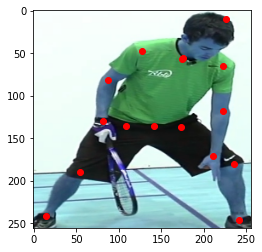

In [227]:
plt.imshow(x_train[4],cmap="gray")
plot_kps(y_train[4])

In [228]:
# model = Sequential()
# model.add(Input(shape = (256,256,1), dtype="float32"))

# model.add(Conv2D(96,kernel_size=(11,11), strides=4, use_bias=True, activation='relu'))

# model.add(MaxPooling2D(pool_size=(3,3), strides=2))

# model.add(Conv2D(256,kernel_size=(5,5), strides=1, use_bias=True, activation='relu',padding='same'))

# model.add(MaxPooling2D(pool_size=(3,3), strides=2))

# model.add(Conv2D(384,kernel_size=(3,3), strides=1, use_bias=True, activation='relu',padding='same'))
# model.add(Conv2D(384,kernel_size=(3,3), strides=1, use_bias=True, activation='relu',padding='same'))
# model.add(Conv2D(256,kernel_size=(3,3), strides=1, use_bias=True, activation='relu',padding='same'))

# model.add(MaxPooling2D(pool_size=(3,3), strides=2))

# model.add(Flatten())

# model.add(Dense(4096, activation='relu'))

# model.add(Dropout(0.5))

# model.add(Dense(4096, activation='relu'))

# model.add(Dropout(0.5))

# model.add(Dense(32, activation='linear'))

# model.summary()

model = Sequential()
model.add(Input(shape = (256,256,3), dtype="float32"))

model.add(Conv2D(96,kernel_size=(5,5), strides=3, use_bias=True, activation='relu'))

model.add(MaxPooling2D(pool_size=(3,3), strides=2))

model.add(Conv2D(128,kernel_size=(3,3), strides=1, use_bias=True, activation='relu'))

model.add(MaxPooling2D(pool_size=(3,3), strides=2))

model.add(Conv2D(256,kernel_size=(3,3), strides=1, use_bias=True, activation='relu'))

model.add(MaxPooling2D(pool_size=(3,3), strides=2))


model.add(Flatten())

model.add(Dense(32,activation='linear'))

model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_99 (Conv2D)           (None, 84, 84, 96)        7296      
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 41, 41, 96)        0         
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 39, 39, 128)       110720    
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 19, 19, 128)       0         
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 17, 17, 256)       295168    
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 8, 8, 256)         0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 16384)           

In [229]:
model.compile( optimizer="adam" , loss="mse", metrics=['accuracy'])

In [231]:
model.fit( x_train, y_train, epochs=100, batch_size=128, validation_split=0.1 )
model.save('model1')

Epoch 1/100
6/6 [==============================] - 13s 2s/step - loss: 0.0671 - accuracy: 0.0167 - val_loss: 0.0634 - val_accuracy: 0.0000e+00
Epoch 2/100
6/6 [==============================] - 12s 2s/step - loss: 0.0654 - accuracy: 0.0153 - val_loss: 0.0639 - val_accuracy: 0.0125
Epoch 3/100
6/6 [==============================] - 12s 2s/step - loss: 0.0653 - accuracy: 0.0139 - val_loss: 0.0624 - val_accuracy: 0.0125
Epoch 4/100
6/6 [==============================] - 12s 2s/step - loss: 0.0641 - accuracy: 0.0139 - val_loss: 0.0629 - val_accuracy: 0.0125
Epoch 5/100
6/6 [==============================] - 12s 2s/step - loss: 0.0631 - accuracy: 0.0153 - val_loss: 0.0610 - val_accuracy: 0.0125
Epoch 6/100
6/6 [==============================] - 12s 2s/step - loss: 0.0619 - accuracy: 0.0167 - val_loss: 0.0604 - val_accuracy: 0.0250
Epoch 7/100
6/6 [==============================] - 12s 2s/step - loss: 0.0611 - accuracy: 0.0181 - val_loss: 0.0600 - val_accuracy: 0.0125
Epoch 8/100
6/6 [======

KeyboardInterrupt: 

In [232]:
model.evaluate(x_test,y_test)

7/7 [==============================] - 1s 142ms/step - loss: 0.0671 - accuracy: 0.1600


[0.0670844167470932, 0.1599999964237213]

In [283]:
p = -1

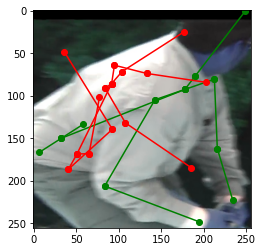

In [334]:
p+=1
input_image = x_test[p]
im = input_image
input_image = input_image.reshape(1,256,256,3)
keypoints = model.predict(input_image)
keypoints = np.squeeze(keypoints)
plot_kps(y_test[p],'green')
plot_kps(keypoints,'red')
plt.imshow(im, cmap="gray")
# only has good accuracy on training dataset so its overfitting